In [22]:
import pandas as pd
import seaborn as sns
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
import pickle
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.activations import relu, sigmoid      # activation functions
from tensorflow.keras.optimizers import SGD                 # stochastic gradient descent
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

In [23]:
df = pd.read_csv("dataset.csv")
df.head(5)

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [24]:
df['is_depression'].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

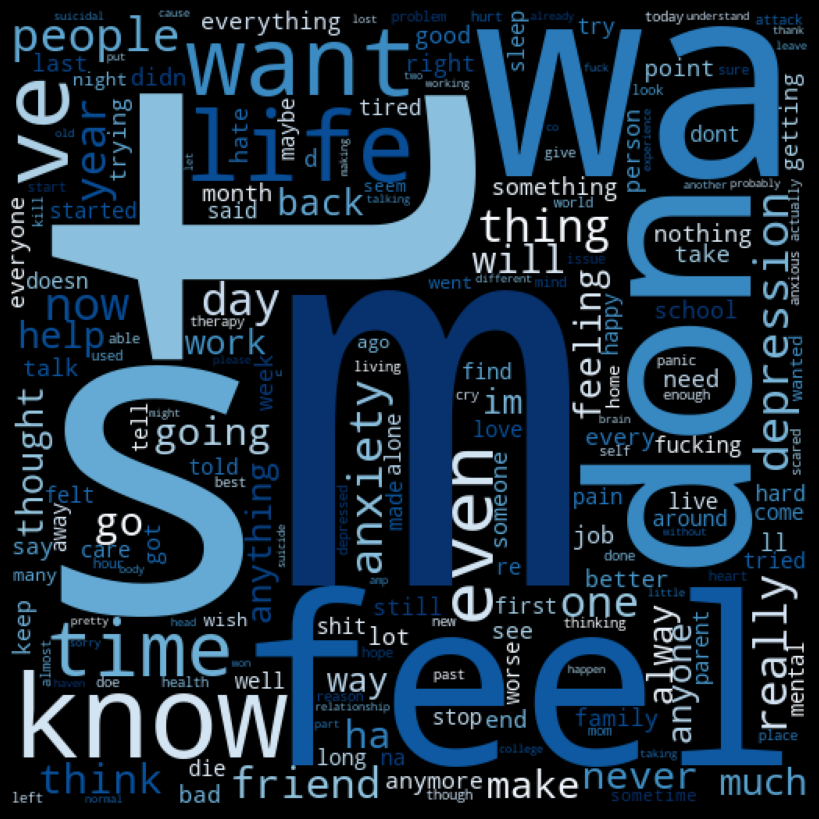

In [25]:
wo = WordNetLemmatizer()
corpus=[]
for i in range(0,len(df)):
    clean_text = re.sub('[^a-zA-Z]',' ',df['clean_text'][i])
    clean_text = clean_text.lower()
    clean_text = clean_text.split()
    clean_text = [wo.lemmatize(word) for word in clean_text ]
    clean_text = ' '.join(clean_text)
    corpus.append(clean_text)
corpus[2]
depressive_words = ' '.join(list(df[df['is_depression'] == 1]['clean_text']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

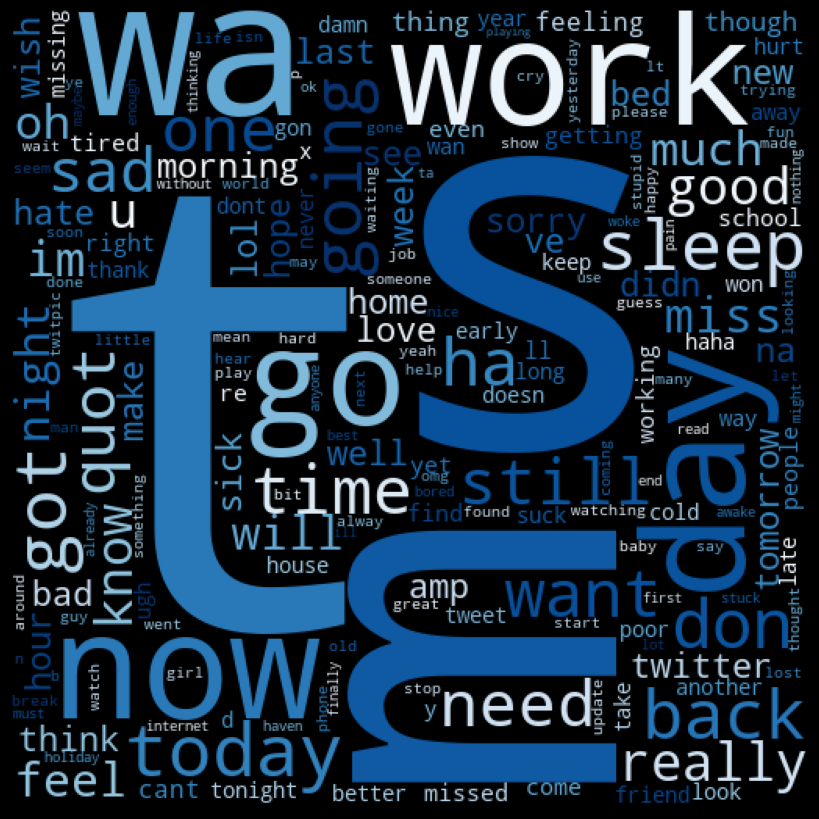

In [26]:
positive_words = ' '.join(list(df[df['is_depression'] == 0]['clean_text']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(corpus,df['is_depression'],test_size=0.25,random_state=42)
vectorizer = TfidfVectorizer( ngram_range=(1,3), stop_words='english',max_features=15000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
X_train_vect.shape

(5798, 15000)

In [28]:
x_resample, y_resample = SMOTE().fit_resample(X_train_vect, y_train)
x_test_resample, y_test_resample = SMOTE().fit_resample(X_test_vect, y_test)
# lets print the shape of x and y after resampling it
print(x_resample.shape)
print(y_resample.shape)

(5824, 15000)
(5824,)


In [29]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(x_resample,y_resample)
y_pred = clf.predict(x_test_resample)
accuracy_score(y_test_resample,y_pred)
print(classification_report(y_test_resample,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       988
           1       0.97      0.92      0.94       988

    accuracy                           0.94      1976
   macro avg       0.95      0.94      0.94      1976
weighted avg       0.95      0.94      0.94      1976



In [30]:
mnb = MultinomialNB()
mnb.fit(x_resample,y_resample)
y_pred = mnb.predict(x_test_resample)
accuracy_score(y_test_resample,y_pred)
print(classification_report(y_test_resample,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87       988
           1       0.82      0.98      0.89       988

    accuracy                           0.88      1976
   macro avg       0.90      0.88      0.88      1976
weighted avg       0.90      0.88      0.88      1976



In [31]:
model = Sequential()
model.add(Dense(units=128, activation=relu, input_shape=(x_resample.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation=sigmoid))
model.compile(
    optimizer=SGD(),
    loss=binary_crossentropy,
    metrics=['accuracy', 'Precision', 'Recall']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1920128   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,928,449
Trainable params: 1,928,449
Non-trainable params: 0
_________________________________________________________________


In [32]:
x_resample

<5824x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 186312 stored elements in Compressed Sparse Row format>

In [33]:
history = model.fit(x_resample.toarray(), y_resample,
        epochs=40, batch_size=16, 
        validation_split=0.2,
        verbose=1, shuffle=True)

Epoch 1/40
292/292 [==============================] - 7s 15ms/step - loss: 0.6925 - accuracy: 0.5362 - precision: 0.5241 - recall: 0.7832 - val_loss: 0.6918 - val_accuracy: 0.5923 - val_precision: 0.7213 - val_recall: 0.3019
Epoch 2/40
292/292 [==============================] - 4s 13ms/step - loss: 0.6903 - accuracy: 0.6171 - precision: 0.6185 - recall: 0.6106 - val_loss: 0.6894 - val_accuracy: 0.6987 - val_precision: 0.6835 - val_recall: 0.7410
Epoch 3/40
292/292 [==============================] - 4s 12ms/step - loss: 0.6867 - accuracy: 0.6720 - precision: 0.6483 - recall: 0.7518 - val_loss: 0.6856 - val_accuracy: 0.7725 - val_precision: 0.7556 - val_recall: 0.8062
Epoch 4/40
292/292 [==============================] - 4s 13ms/step - loss: 0.6821 - accuracy: 0.7238 - precision: 0.7305 - recall: 0.7089 - val_loss: 0.6806 - val_accuracy: 0.6541 - val_precision: 0.5926 - val_recall: 0.9880
Epoch 5/40
292/292 [==============================] - 4s 13ms/step - loss: 0.6753 - accuracy: 0.7643

In [34]:
model.evaluate(x_test_resample.toarray(), y_test_resample)

62/62 [==============================] - 0s 6ms/step - loss: 0.1499 - accuracy: 0.9448 - precision: 0.9583 - recall: 0.9302


[0.14989472925662994,
 0.9448380470275879,
 0.9582898616790771,
 0.9301619529724121]

62/62 [==============================] - 0s 6ms/step


<Axes: >

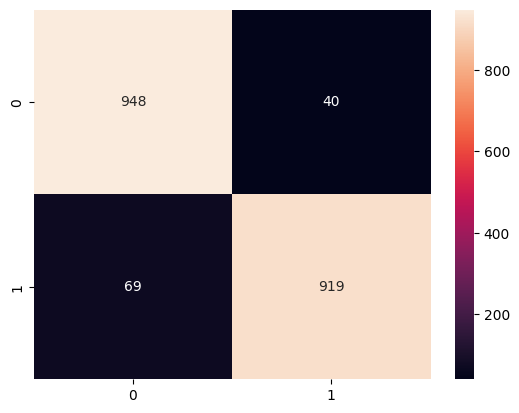

In [35]:
import seaborn as sns
# heatmap
ypred = model.predict(x_test_resample.toarray())
ypred = ypred > 0.5
cm = confusion_matrix(y_test_resample, ypred)
sns.heatmap(cm, annot=True, fmt='d')

In [36]:
print(classification_report(y_test_resample, ypred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       988
           1       0.96      0.93      0.94       988

    accuracy                           0.94      1976
   macro avg       0.95      0.94      0.94      1976
weighted avg       0.95      0.94      0.94      1976



In [37]:
vectorizer

TfidfVectorizer(max_features=15000, ngram_range=(1, 3), stop_words='english')

In [39]:
# test the model
msg = "I am feeling very happy"
data = [msg]
vect = vectorizer.transform(data).toarray()
my_prediction = model.predict(vect)
my_prediction = my_prediction > 0.5
print(my_prediction)


1/1 [==============================] - 0s 238ms/step
[[ True]]


In [118]:
#save the model
from joblib import dump
model.save('mental_health_detection.h5')
dump(vectorizer, 'tfidf_vectorizer.jb')

['tfidf_vectorizer.jb']

In [7]:
#load the model
from joblib import load
def load_model():
    model = tf.keras.models.load_model('mental_health_detection.h5')
    return model

def load_preprocessor():
    v = load('tfidf_vectorizer.jb')
    return v

In [8]:
existing_model = load_model()
v = load_preprocessor()
# existing_model.summary()

In [44]:
def predict(text):
    data = [text]
    vect = vectorizer.transform(data).toarray()
    my_prediction = model.predict(vect)
    my_prediction = my_prediction > 0.5
    return my_prediction[0][0]

predict("I am feeling very happy")

1/1 [==============================] - 0s 49ms/step


False

In [68]:
# stt
import speech_recognition as sr 
import pyttsx3
import pyaudio

def speak(text):
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()
    
def get_audio():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        audio = r.listen(source)
        said = ""
        
        try:
            said = r.recognize_google(audio)
            print(said)
        except Exception as e:
            print("Exception: " + str(e))
            
    return said

text = get_audio()
speak("You said " + text)
print(predict(text))


I am not feeling good
1/1 [==============================] - 0s 37ms/step
False
